**LOAD HTMLS FILES TO A JSON FILE**

In [ ]:
# Import all neccessary libraries
import os
import re
import json
import nltk
import torch
import numpy as np
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from collections import Counter
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.stats import pearsonr
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
# Replace this with the path to the directory where your HTML files are stored
extract_path = 'path/to/your/dataset'

chat_texts = {}
malformed_files = []
file_sizes = []

for filename in os.listdir(extract_path):
    if filename.endswith('.html'):
        file_path = os.path.join(extract_path, filename)
        file_size = os.path.getsize(file_path)
        file_sizes.append(file_size)

        try:
            if file_size <= 10000:
                raise ValueError("Empty file")

            with open(file_path, 'r', encoding='utf-8') as file:
                soup = BeautifulSoup(file, 'lxml')
                chat_text = soup.get_text().strip()

                if len(chat_text) < 200:
                    raise ValueError("Insufficient content in file")

                chat_texts[filename] = chat_text

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            malformed_files.append(filename)

# Find the mode of file sizes
mode_file_size = Counter(file_sizes).most_common(1)[0][0]

# Select a file with the mode file size for imputation
mode_file_path = next(file for file, size in zip(chat_texts.keys(), file_sizes) if size == mode_file_size)
with open(os.path.join(extract_path, mode_file_path), 'r', encoding='utf-8') as file:
    mode_file_content = BeautifulSoup(file, 'lxml').get_text().strip()

# Data Imputation for Malformed Files
for malformed_file in malformed_files:
    chat_texts[malformed_file] = mode_file_content

# Save chat_texts and malformed_files to JSON files
# Change the paths to a general directory or instruct users to specify their own
chat_texts_json_path = os.path.join('output', 'chat_texts.json')
malformed_files_json_path = os.path.join('output', 'malformed_files.json')

with open(chat_texts_json_path, 'w', encoding='utf-8') as file:
    json.dump(chat_texts, file, ensure_ascii=False, indent=4)

with open(malformed_files_json_path, 'w', encoding='utf-8') as file:
    json.dump(malformed_files, file, ensure_ascii=False, indent=4)

Error processing b0640e51-6879-40cb-a4f5-329f952ef99d.html: Empty file
Error processing 139235c7-736c-4237-92f0-92e8c116832c.html: Empty file
Error processing 668ad17e-0240-49f7-b5a7-d22e502554c6.html: Empty file
Error processing da6b70d5-29f6-491a-ad46-037c77067128.html: Empty file


**VISUALIZE SCORE DATA**

Missing values before imputation: Unnamed: 0    0
code          0
grade         1
dtype: int64
Missing values after imputation: Unnamed: 0    0
code          0
grade         0
dtype: int64
       Unnamed: 0       grade
count  145.000000  145.000000
mean    72.000000   91.965278
std     42.001984   11.694261
min      0.000000   15.000000
25%     36.000000   89.000000
50%     72.000000   95.000000
75%    108.000000   99.000000
max    144.000000  100.000000


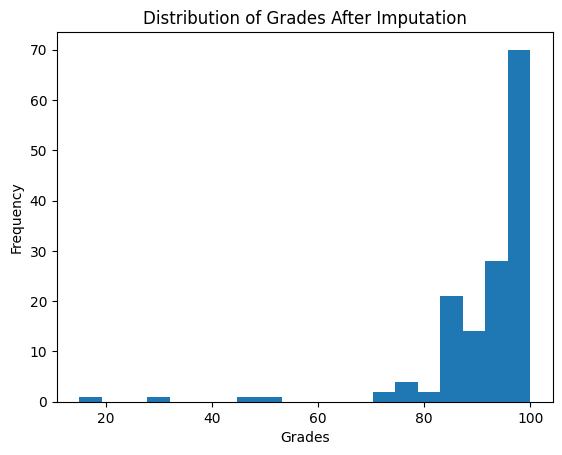

In [ ]:
# # Replace 'path_to_your_scores.csv' with your scores.csv file path
scores_path = 'path_to_your_scores.csv'  

# Read the CSV data into a DataFrame
scores_df = pd.read_csv(scores_path)

# Check for missing data
print("Missing values before imputation:", scores_df.isnull().sum())

# Replace missing values with the mean of the 'grade' column
mean_score = scores_df['grade'].mean()
scores_df['grade'].fillna(mean_score, inplace=True)

# Check if missing values are filled
print("Missing values after imputation:", scores_df.isnull().sum())

# Display summary statistics of the DataFrame
print(scores_df.describe())

# Plotting the distribution of grades
plt.hist(scores_df['grade'], bins=20)
plt.xlabel('Grades')
plt.ylabel('Frequency')
plt.title('Distribution of Grades After Imputation')
plt.show()

**FORMAT CHAT TEXT TO DETECT QUESTION AND ANSWERS**

In [ ]:
# Function to extract prompt/answers pairs from the whole text for each student
def extract_prompt_response(chat_text):
    prompts = []
    responses = []
    current_index = 0
    first_question = True

    while True:
        if first_question:
            prompt_index = chat_text.find('TITLEAnonymous', current_index)
            prefix_length = len('TITLEAnonymous')
            first_question = False
        else:
            prompt_index = chat_text.find('Anonymous', current_index)
            prefix_length = len('Anonymous')

        response_index = chat_text.find('ChatGPTChatGPT', current_index)

        if prompt_index == -1 or response_index == -1:
            break

        prompt = chat_text[current_index + prefix_length:response_index].strip()
        current_index = response_index + len('ChatGPTChatGPT')

        next_prompt_index = chat_text.find('Anonymous', current_index)
        response = chat_text[response_index + len('ChatGPTChatGPT'):next_prompt_index].strip()

        prompts.append(prompt)
        responses.append(response)

        if next_prompt_index != -1:
            current_index = next_prompt_index
        else:
            break

    return list(zip(prompts, responses))

# Path to your JSON file containing the extracted texts
json_file_path = 'path_to_your_chat_texts.json'  # Replace 'path_to_your_chat_texts.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    chat_texts = json.load(file)

def word_count(text):
    """ Count the number of words in a given text. """
    return len(text.split())

# Process each chat text to extract prompt-response pairs and count words
prompt_answer_pairs = {}
for filename, chat_text in chat_texts.items():
    pairs = extract_prompt_response(chat_text)
    total_words = sum(word_count(prompt) + word_count(response) for prompt, response in pairs)
    prompt_answer_pairs[filename] = {"pairs": pairs, "scores": {}, "number_of_words": total_words}

with open(json_file_path, 'w', encoding='utf-8') as file:
    json.dump(prompt_answer_pairs, file, ensure_ascii=False, indent=4)

**READ THE ASSIGNMENT.ipynb FILE**

In [ ]:
# Path to your Assignment Notebook file (`.ipynb`)
ipynb_file_path = 'path_to_your_Assignment.ipynb'  # Replace 'path_to_your_Assignment.ipynb' with your file path

# Load the content of the IPython Notebook
with open(ipynb_file_path, 'r', encoding='utf-8') as file:
    notebook_data = json.load(file)

# Determine the save directory and path for the JSON output
save_directory = os.path.dirname(ipynb_file_path)
json_file_path = os.path.join(save_directory, 'notebook_data.json')

# Save the Notebook content as JSON
with open(json_file_path, 'w', encoding='utf-8') as file:
    json.dump(notebook_data, file, indent=4)

In [ ]:
# Function to extract questions from the text exctracted from assignment.ipynb file
def extract_questions(notebook_data):
    question_data = {}
    current_question = None
    question_content = []

    question_pattern = re.compile(r"## (\d+)\)")

    for cell in notebook_data["cells"]:
        if cell["cell_type"] == "markdown":
            # Check if the cell is the start of a new question
            if (match := question_pattern.search(''.join(cell["source"]))):
                if current_question is not None:
                    # Save the previous question data
                    question_data[current_question] = question_content
                    question_content = []

                current_question = f"Question {match.group(1)}"
                question_content.append(cell)
            elif current_question is not None:
                # Continue adding cells to the current question
                question_content.append(cell)
        elif current_question is not None:
            # Add code cells to the current question
            question_content.append(cell)

    # Add the last question
    if current_question is not None:
        question_data[current_question] = question_content

    return question_data

# Path to your JSON file containing the assignment notebook data
ipynb_file_path = 'path_to_your_notebook_data.json'  # Replace 'path_to_your_notebook_data.json' with your file path

with open(ipynb_file_path, 'r', encoding='utf-8') as file:
    notebook_data = json.load(file)

# Extract questions and their content
questions = extract_questions(notebook_data)

# Determine the path to save the extracted questions data
questions_json_path = os.path.join(os.path.dirname(ipynb_file_path), 'questions_data.json')

# Save the extracted questions data as JSON
with open(questions_json_path, 'w', encoding='utf-8') as file:
    json.dump(questions, file, indent=4)

**FIND SIMILARITY BETWEEN EACH QUESTION AND EACH HTML FILE'S TEXT**

In [ ]:
pip install transformers torch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
model = AutoModel.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")

In [ ]:
# Function to extract text embedding based on the define model
def embed_text(text, tokenizer, model):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(1)
    return embeddings

In [ ]:
def calculate_similarity(embedding1, embedding2):
    """Calculate the similarities between two text embedings."""
    return cosine_similarity(embedding1.detach().numpy(), embedding2.detach().numpy())[0][0]

In [ ]:
def concatenate_sources(cells):
    """Concatenate the 'source' text from a list of cell dictionaries into a single string."""
    concatenated_text = ""
    for cell in cells:
        if 'source' in cell:
            # Concatenate the lines in 'source'
            concatenated_text += ' '.join(cell['source']).strip() + " "
    return concatenated_text.strip()

In [ ]:
# Function to clean and preprocess text for prompt/question pairs JSON file
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return ' '.join(stemmed_tokens)

# Path to your JSON file containing prompt-answer pairs
json_file_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Preprocess the text in pairs
for html_id, content in formatted_data.items():
    if 'pairs' in content:
        preprocessed_pairs = []
        for pair in content['pairs']:
            preprocessed_pair = [preprocess_text(text) for text in pair]
            preprocessed_pairs.append(preprocessed_pair)
        formatted_data[html_id]['pairs'] = preprocessed_pairs

# Save the preprocessed data back to the same JSON file
with open(json_file_path, 'w', encoding='utf-8') as file:
    json.dump(formatted_data, file, indent=4)

In [ ]:
# Function to preprocess the question text from the assignment file
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    # Reassemble the text
    return ' '.join(stemmed_tokens)

# Path to your JSON file containing questions data
json_file_path = 'path_to_your_questions_data.json'  # Replace 'path_to_your_questions_data.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    questions_data = json.load(file)

# Preprocess the text in each question
for question_id, cells in questions_data.items():
    preprocessed_text = []
    for cell in cells:
        if 'source' in cell:
            # Concatenate all lines in 'source'
            cell_text = ' '.join(cell['source'])
            # Preprocess the concatenated text
            preprocessed_text.append(preprocess_text(cell_text))
    # Update the question with preprocessed text
    questions_data[question_id] = preprocessed_text

# Save the preprocessed data back to the same JSON file
with open(json_file_path, 'w', encoding='utf-8') as file:
    json.dump(questions_data, file, indent=4)

In [ ]:
# Load the data from the 'questions_data.json' file
with open('path_to_your_questions_data.json', 'r') as file:
    question_data = json.load(file)

# Load the data from the 'prompt_answer_pairs.json' file
with open('path_to_your_prompt_answer_pairs.json', 'r') as file:
    chat_texts = json.load(file)

# Initialize a dictionary to store similarity scores for each HTML file
html_similarity_scores = {chat_id: {} for chat_id in chat_texts.keys()}

# Calculate similarities
for q_id, q_contents in question_data.items():
    # Concatenate all texts for each question
    q_text = ' '.join(q_contents)
    q_embedding = embed_text(q_text, tokenizer, model)
    for chat_id, chat_data in chat_texts.items():
        # Concatenate all texts from pairs for embedding
        all_chat_text = ' '.join([' '.join(pair) for pair in chat_data['pairs']])
        chat_embedding = embed_text(all_chat_text, tokenizer, model)
        similarity = calculate_similarity(q_embedding, chat_embedding) 
        html_similarity_scores[chat_id][f"q_{q_id[-1]}_similarity"] = similarity

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

# Load the data from the formatted JSON file
with open(formatted_json_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Update the formatted_data with similarity scores and calculate averages
for html_id, scores in html_similarity_scores.items():
    if html_id in formatted_data:
        # Convert scores to standard Python floats
        formatted_scores = {k: float(v) for k, v in scores.items()}
        formatted_data[html_id]['scores'] = formatted_scores

        # Calculate and add the average similarity score
        average_score = sum(formatted_scores.values()) / len(formatted_scores) if formatted_scores else 0
        formatted_data[html_id]['scores']['average_similarity'] = average_score

# Save the updated formatted data back to the same JSON file
with open(formatted_json_path, 'w', encoding='utf-8') as file:
    json.dump(formatted_data, file, indent=4)

**PLOT HISTOGRAM OF SIMILARITY SCORES FOR EACH QUESTION**

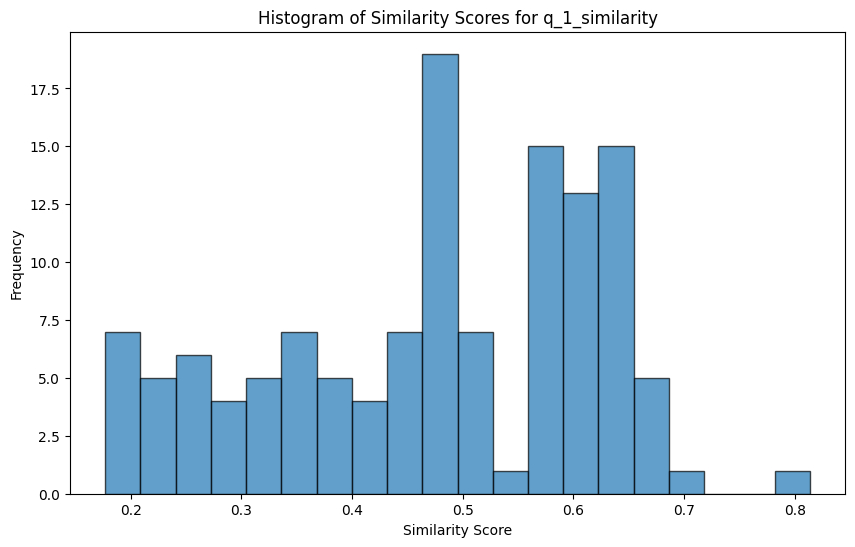

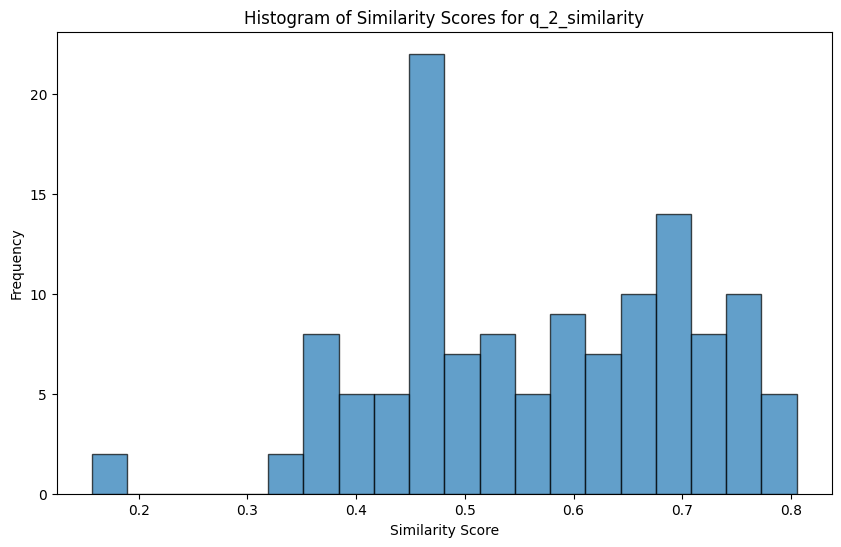

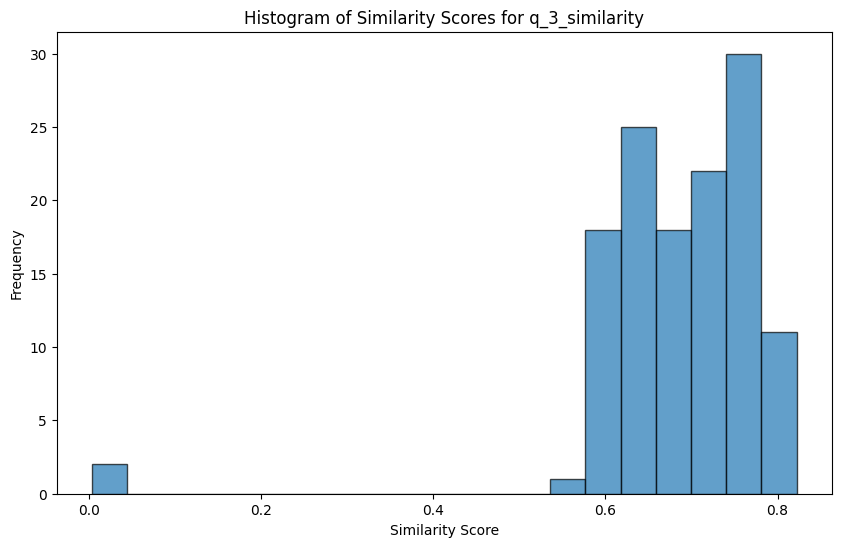

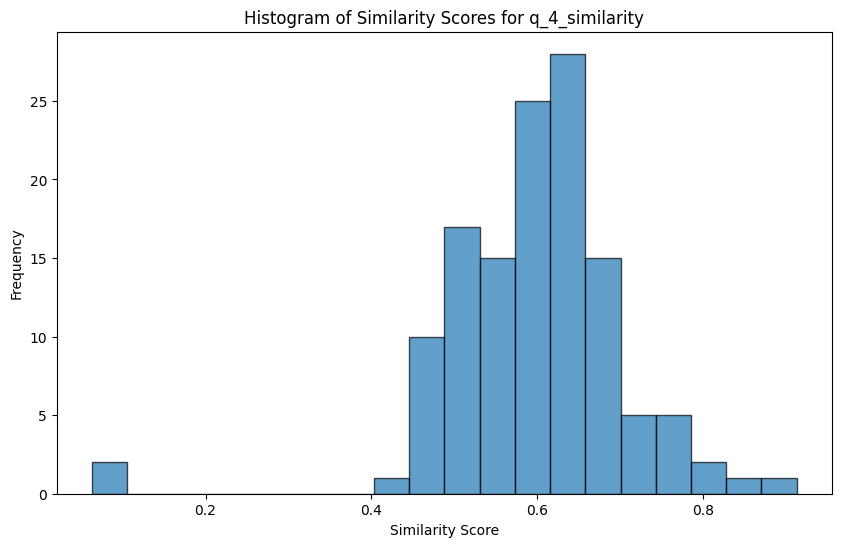

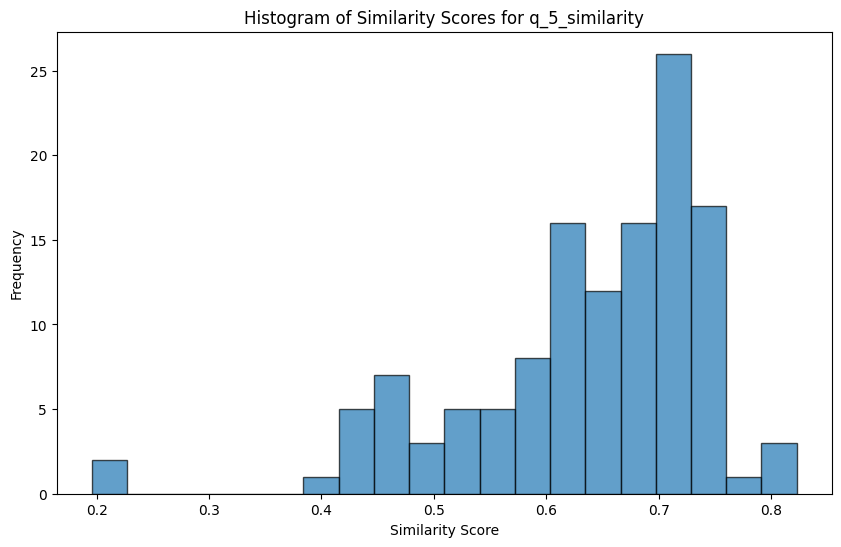

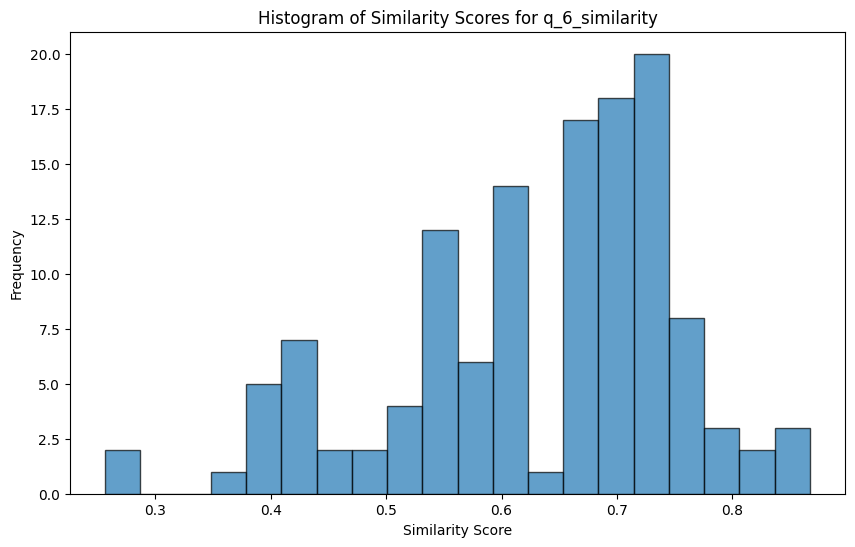

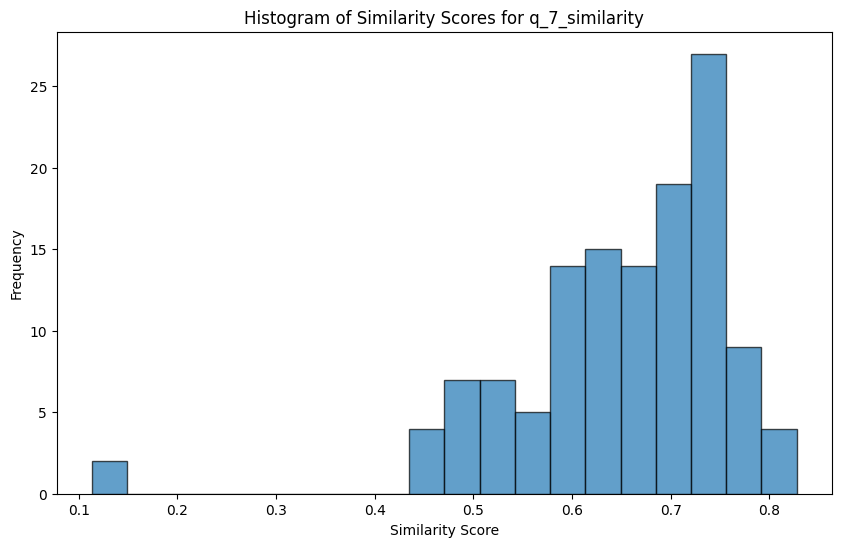

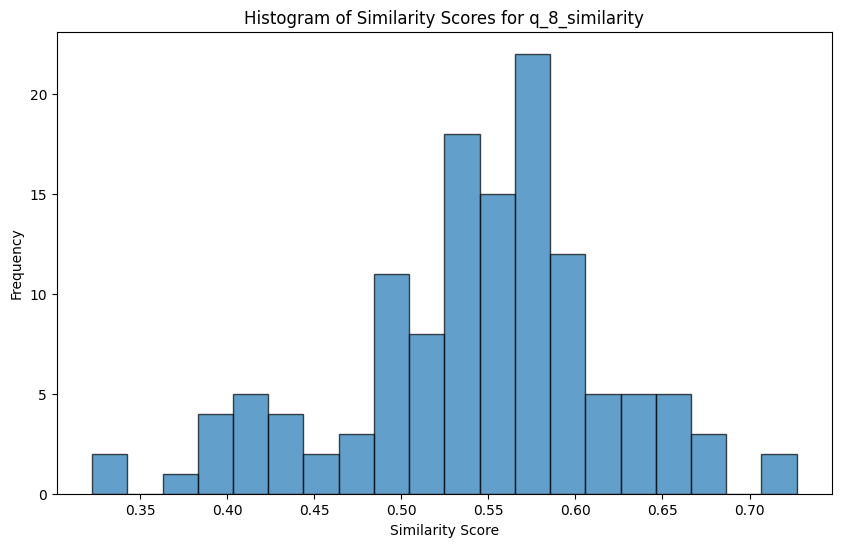

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(formatted_json_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extracting similarity scores for questions 1 through 8
question_similarities = {f"q_{i}_similarity": [] for i in range(1, 9)}

for entry in formatted_data.values():
    if 'scores' in entry:
        for q, score in entry['scores'].items():
            if q in question_similarities:
                question_similarities[q].append(score)

# Plotting histograms for each question's similarity scores
for q, scores in question_similarities.items():
    plt.figure(figsize=(10, 6))
    plt.hist(scores, bins=20, edgecolor='k', alpha=0.7)
    plt.title(f"Histogram of Similarity Scores for {q}")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.show()

**RELATIONSHIP BETWEEN AVERAGE SIMILARITY OF THE TEXTS OF THE QUESTION IN THE HW VS THE GRADES**

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Update the JSON data with grades under "scores"
for _, row in scores_df.iterrows():
    html_id = row['code'] + '.html'
    grade = row['grade']
    if html_id in formatted_data and 'scores' in formatted_data[html_id]:
        formatted_data[html_id]['scores']['grade'] = grade

with open(json_file_path, 'w', encoding='utf-8') as file:
    json.dump(formatted_data, file, indent=4)

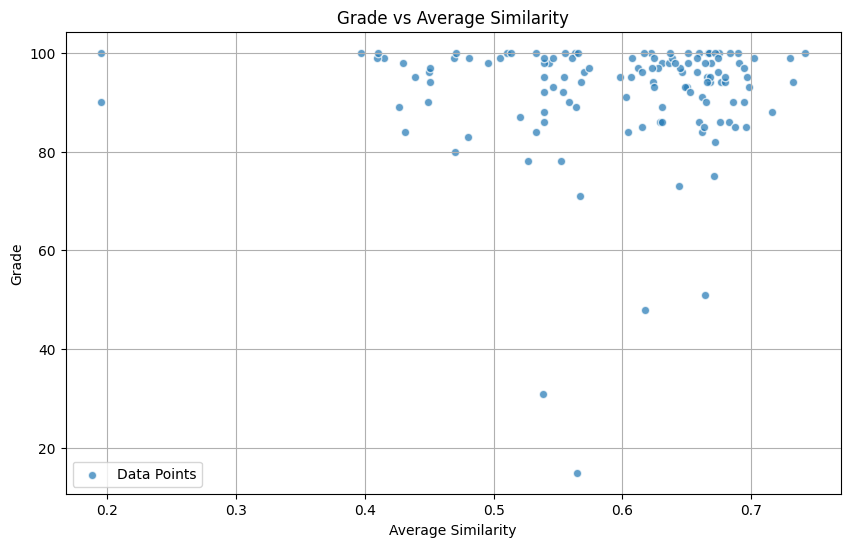

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract average_similarity and grade
average_similarities = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry:
        scores = entry['scores']
        if 'average_similarity' in scores and 'grade' in scores:
            average_similarities.append(scores['average_similarity'])
            grades.append(scores['grade'])

# Plotting grade against average_similarity
plt.figure(figsize=(10, 6))
plt.scatter(average_similarities, grades, alpha=0.7, edgecolors='w', label='Data Points')

plt.xlabel('Average Similarity')
plt.ylabel('Grade')
plt.title('Grade vs Average Similarity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract average_similarity and grade
average_similarities = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry:
        scores = entry['scores']
        if 'average_similarity' in scores and 'grade' in scores:
            average_similarities.append(scores['average_similarity'])
            grades.append(scores['grade'])

X = np.array(average_similarities).reshape(-1, 1)  # Feature
y = np.array(grades)  # Target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# Clip predictions to ensure they are within the range 0-100
y_pred_clipped = np.clip(y_pred, 0, 100)

# Calculate and print the performance metrics
mse = mean_squared_error(y_val, y_pred_clipped)
r2 = r2_score(y_val, y_pred_clipped)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 41.986395757625786
R-squared Score: -0.39927053501060117


**RELATIONSHIP BETWEEN NUMBER OF THE WORDS IN PROMPTS AND THE GRADES**

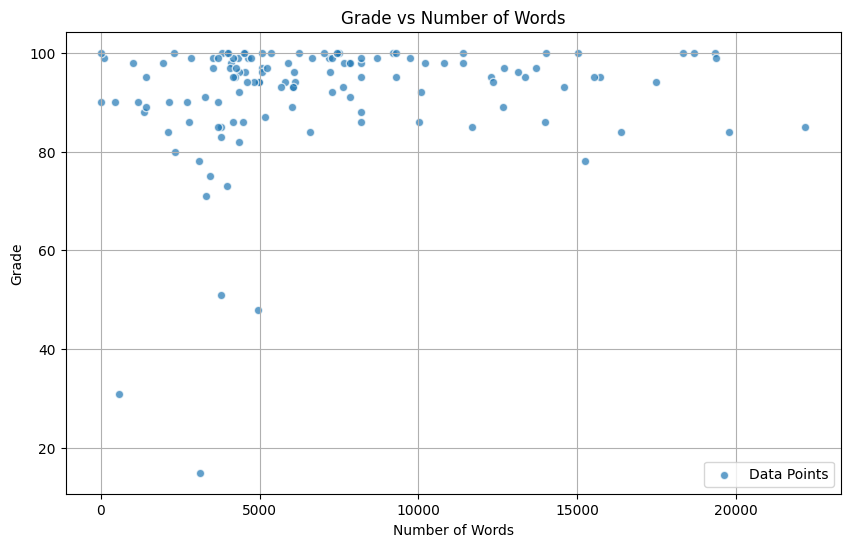

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract number_of_words and grade
word_counts = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry and 'grade' in entry['scores'] and 'number_of_words' in entry:
        word_counts.append(entry['number_of_words'])
        grades.append(entry['scores']['grade'])

# Plotting number_of_words against grade
plt.figure(figsize=(10, 6))
plt.scatter(word_counts, grades, alpha=0.7, edgecolors='w', label='Data Points')

plt.xlabel('Number of Words')
plt.ylabel('Grade')
plt.title('Grade vs Number of Words in Prompts')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract number_of_words and grade
word_counts = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry and 'grade' in entry['scores'] and 'number_of_words' in entry:
        word_counts.append(entry['number_of_words'])
        grades.append(entry['scores']['grade'])

# Convert lists to numpy arrays
X = np.array(word_counts).reshape(-1, 1)
y = np.array(grades)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# Clip predictions to ensure they are within the range 0-100
y_pred_clipped = np.clip(y_pred, 0, 100)

# Calculate and print the performance metrics
mse = mean_squared_error(y_val, y_pred_clipped)
r2 = r2_score(y_val, y_pred_clipped)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 56.67080214367846
R-squared Score: -0.8886542224968763


**RELATIONSHIP BETWEEN NUMBER OF QUESTIONS AND THE GRADES**

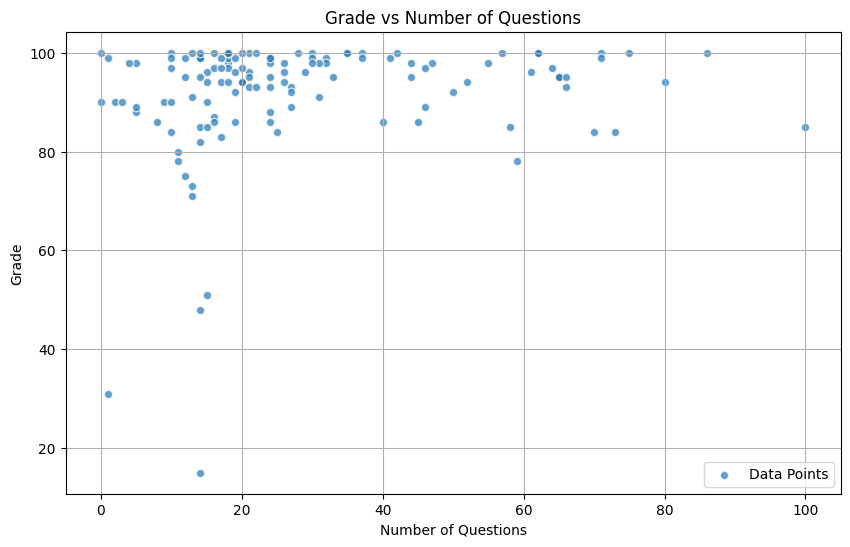

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract number_of_questions and grade
number_of_questions = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry and 'grade' in entry['scores'] and 'pairs' in entry:
        num_questions = len(entry['pairs'])
        number_of_questions.append(num_questions)
        grades.append(entry['scores']['grade'])

# Plotting number_of_questions against grade
plt.figure(figsize=(10, 6))
plt.scatter(number_of_questions, grades, alpha=0.7, edgecolors='w', label='Data Points')

plt.xlabel('Number of Questions')
plt.ylabel('Grade')
plt.title('Grade vs Number of Questions')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract number_of_questions and grade
number_of_questions = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry and 'grade' in entry['scores'] and 'pairs' in entry:
        num_questions = len(entry['pairs'])
        number_of_questions.append(num_questions)
        grades.append(entry['scores']['grade'])

# Convert lists to numpy arrays
X = np.array(number_of_questions).reshape(-1, 1)
y = np.array(grades)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# Clip predictions to ensure they are within the range 0-100
y_pred_clipped = np.clip(y_pred, 0, 100)

# Calculate and print the performance metrics
mse = mean_squared_error(y_val, y_pred_clipped)
r2 = r2_score(y_val, y_pred_clipped)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 55.59799304446039
R-squared Score: -0.8529009711129572


**RELATIONSHIP BETWEEN AVG SENITIMENT OF QUESTIONS AND THE GRADES**

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Function to calculate average sentiment of a list of texts
def average_sentiment(texts):
    total_sentiment = sum(TextBlob(text).sentiment.polarity for text in texts)
    return total_sentiment / len(texts) if texts else 0

# Calculate average sentiment for each HTML ID
for entry in data.values():
    questions = [pair[0] for pair in entry['pairs']]  # Extract questions
    avg_sentiment = average_sentiment(questions)
    if 'scores' in entry:
        entry['scores']['avg_sentiment'] = avg_sentiment

with open(json_file_path, 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4)

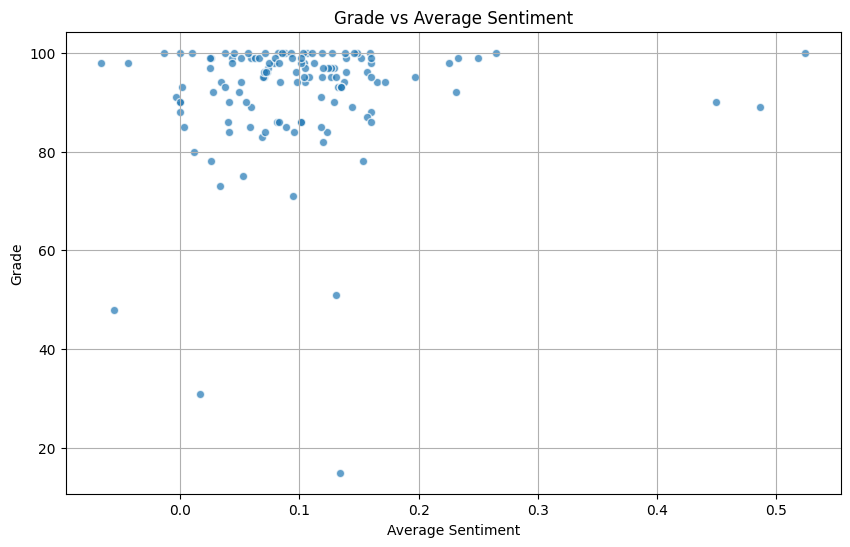

Correlation coefficient: 0.10751562842802402


In [ ]:
grades = []
avg_sentiments = []

for entry in data.values():
    if 'scores' in entry:
        scores = entry['scores']
        if 'grade' in scores and 'avg_sentiment' in scores:
            grades.append(scores['grade'])
            avg_sentiments.append(scores['avg_sentiment'])

plt.figure(figsize=(10, 6))
plt.scatter(avg_sentiments, grades, alpha=0.7, edgecolors='w')
plt.xlabel('Average Sentiment')
plt.ylabel('Grade')
plt.title('Grade vs Average Sentiment')
plt.grid(True)
plt.show()

correlation, _ = pearsonr(avg_sentiments, grades)
print("Correlation coefficient:", correlation)

In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract average sentiment and grade
avg_sentiments = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry and 'grade' in entry['scores'] and 'avg_sentiment' in entry['scores']:
        avg_sentiments.append(entry['scores']['avg_sentiment'])
        grades.append(entry['scores']['grade'])

X = np.array(avg_sentiments).reshape(-1, 1)  # Feature
y = np.array(grades)  # Target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# Clip predictions to ensure they are within the range 0-100
y_pred_clipped = np.clip(y_pred, 0, 100)

# Calculate and print the performance metrics
mse = mean_squared_error(y_val, y_pred_clipped)
r2 = r2_score(y_val, y_pred_clipped)
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 40.73659556302244
R-squared Score: -0.3576187438672438


**RELATIONSHIP BETWEEN AVG LENGTH OF PROMPTS AND THE GRADE**

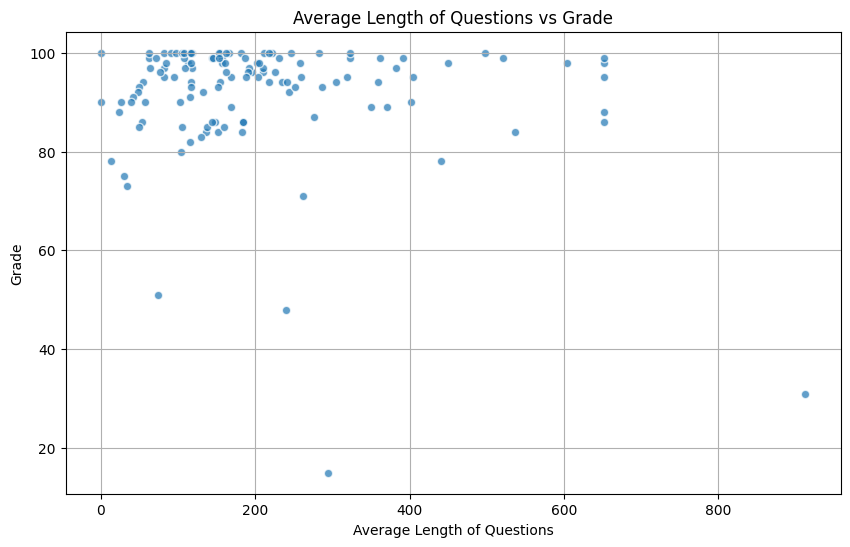

Mean Squared Error: 41.57439906495908
R-squared Score: -0.3855400201100543


In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract avg length of questions and grade
avg_length_of_questions = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry and 'grade' in entry['scores'] and 'pairs' in entry:
        total_length = sum(len(pair[0]) for pair in entry['pairs'])
        avg_length = total_length / len(entry['pairs']) if entry['pairs'] else 0
        avg_length_of_questions.append(avg_length)
        grades.append(entry['scores']['grade'])

X = np.array(avg_length_of_questions).reshape(-1, 1)
y = np.array(grades)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# Clip predictions to ensure they are within the range 0-100
y_pred_clipped = np.clip(y_pred, 0, 100)

mse = mean_squared_error(y_val, y_pred_clipped)
r2 = r2_score(y_val, y_pred_clipped)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolors='w')
plt.xlabel('Average Length of Questions')
plt.ylabel('Grade')
plt.title('Average Length of Questions vs Grade')
plt.grid(True)
plt.show()

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

**RELATIONSHIP BETWEEN AVG LENGTH OF GPT RESPONSE AND THE GRADE**

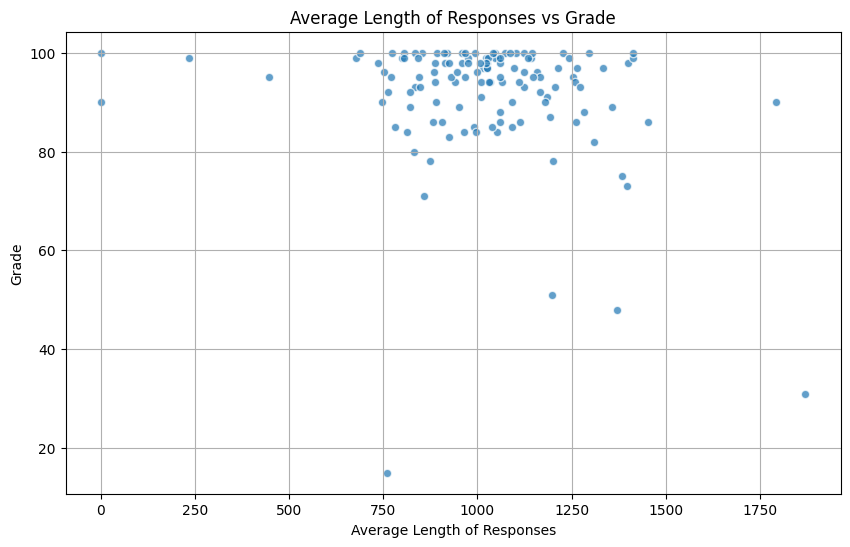

Mean Squared Error: 38.42842964626688
R-squared Score: -0.2806950523011442


In [ ]:
# Define the path to your prompt/answer JSON file
formatted_json_path = 'path_to_your_prompt_answer_pairs.json'  # Replace 'path_to_your_prompt_answer_pairs.json' with your file path

with open(json_file_path, 'r', encoding='utf-8') as file:
    formatted_data = json.load(file)

# Extract avg length of questions and grade
avg_length_of_responses = []
grades = []

for entry in formatted_data.values():
    if 'scores' in entry and 'grade' in entry['scores'] and 'pairs' in entry:
        total_length = sum(len(pair[1]) for pair in entry['pairs'])
        avg_length = total_length / len(entry['pairs']) if entry['pairs'] else 0
        avg_length_of_responses.append(avg_length)
        grades.append(entry['scores']['grade'])

X = np.array(avg_length_of_responses).reshape(-1, 1)
y = np.array(grades)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

# Clip predictions to ensure they are within the range 0-100
y_pred_clipped = np.clip(y_pred, 0, 100)

mse = mean_squared_error(y_val, y_pred_clipped)
r2 = r2_score(y_val, y_pred_clipped)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.7, edgecolors='w')
plt.xlabel('Average Length of Responses')
plt.ylabel('Grade')
plt.title('Average Length of Responses vs Grade')
plt.grid(True)
plt.show()

print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")